In [1]:
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

#Basic imports
import numpy as np
import pandas as pd

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [10]:
df = pd.read_csv('../data_TM2/processed/processed_utterances_sentence_DA_labeling.csv', index_col=0)
# df['concat_da_names'] = df.iloc[:, 8:21].apply(lambda row: row.dropna().tolist(), axis=1)
df = df.iloc[:10000,:]
df.head()

,task,conversation_id,instruction_id,index,speaker,text,segments,new_text,DA_rep_init,DA_greet,...,DA_receipt,DA_disconf,DA_closer,DA_comp_check,DA_hold,DA_partial_req,DA_detail_req,DA_grant,DA_answer,all_DA
0,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,0,U,Hello. I'd like to find a round trip commercia...,"[{'start_index': 26, 'end_index': 36, 'text': ...",Hello.,NaN,U_greeting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['U_greeting']
1,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,0,U,Hello. I'd like to find a round trip commercia...,"[{'start_index': 26, 'end_index': 36, 'text': ...",I'd like to find a round trip commercial airli...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
2,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,1,A,"Hello, how can I help you?",NaN,"Hello, how can I help you?",NaN,A_greeting,...,NaN,NaN,NaN,NaN,NaN,NaN,A_detail_request,NaN,NaN,"['A_greeting', 'A_detail_request']"
3,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,2,A,"San Francisco to Denver, got it.","[{'start_index': 0, 'end_index': 13, 'text': '...","San Francisco to Denver, got it.",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['A_confirmation']
4,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,3,U,You're really on top of things. I like that.,NaN,You're really on top of things.,NaN,U_greeting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['U_greeting']


In [11]:
df_to_cluster = df.iloc[:, 8:21]
df_to_cluster.columns

Index(['DA_rep_init', 'DA_greet', 'DA_req_sum', 'DA_conf', 'DA_receipt',
       'DA_disconf', 'DA_closer', 'DA_comp_check', 'DA_hold', 'DA_partial_req',
       'DA_detail_req', 'DA_grant', 'DA_answer'],
      dtype='object')

In [12]:
DA = ['repair_initiator','greeting','request_summary','confirmation','receipt','disconfirmation',
      'sequence_closer','completion_check','hold_request','partial_request', 'detail_request', 'grant', 'answer'] 

for e,i in enumerate(DA):
    print(e,i, e+8) #(class number, original tag, column number)
    df_to_cluster.iloc[:,e] = df_to_cluster.iloc[:,e].replace(i, 1)
    df_to_cluster.iloc[:,e] = df_to_cluster.iloc[:,e].fillna(0)
    
df_to_cluster

0 repair_initiator 8
1 greeting 9
2 request_summary 10
3 confirmation 11
4 receipt 12
5 disconfirmation 13
6 sequence_closer 14
7 completion_check 15
8 hold_request 16
9 partial_request 17
10 detail_request 18
11 grant 19
12 answer 20


,DA_rep_init,DA_greet,DA_req_sum,DA_conf,DA_receipt,DA_disconf,DA_closer,DA_comp_check,DA_hold,DA_partial_req,DA_detail_req,DA_grant,DA_answer
0,0,U_greeting,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,A_greeting,0,0,0,0,0,0,0,0,A_detail_request,0,0
3,0,0,0,A_confirmation,0,0,0,0,0,0,0,0,0
4,0,U_greeting,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,A_disconfirmation,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,0,U_greeting,0,0,0,0,0,0,0,U_partial_request,0,0,0
9998,0,0,0,A_confirmation,0,0,0,0,0,0,0,A_grant,0


In [13]:
#select only labeled dataset

df.dropna(subset=['DA_rep_init', 'DA_greet', 'DA_req_sum',
       'DA_conf', 'DA_receipt', 'DA_disconf', 'DA_closer', 'DA_comp_check',
       'DA_hold', 'DA_partial_req', 'DA_detail_req', 'DA_grant', 'DA_answer'], how='all', inplace = True)

print(len(df))

7662


In [14]:
DA = ['repair_initiator','greeting','request_summary','confirmation','receipt','disconfirmation',
      'sequence_closer','completion_check','hold_request','partial_request', 'detail_request', 'grant', 'answer'] 

#replace tags per number of class
for e,i in enumerate(DA):
    print(e,i, e+8) #(class number, original tag, column number)
    df.iloc[:,e+8] = df.iloc[:,e+8].replace(i, (e+1))
    df.iloc[:,e+8] = df.iloc[:,e+8].fillna(0)

#     df.iloc[:,e+8] =df.iloc[:,e+8].astype(int)
    
df['concat_col'] = df.iloc[:, 8:21].apply(lambda row: row.dropna().tolist(), axis=1)

0 repair_initiator 8
1 greeting 9
2 request_summary 10
3 confirmation 11
4 receipt 12
5 disconfirmation 13
6 sequence_closer 14
7 completion_check 15
8 hold_request 16
9 partial_request 17
10 detail_request 18
11 grant 19
12 answer 20


In [25]:
df

,task,conversation_id,instruction_id,index,speaker,text,segments,new_text,DA_rep_init,DA_greet,...,DA_disconf,DA_closer,DA_comp_check,DA_hold,DA_partial_req,DA_detail_req,DA_grant,DA_answer,all_DA,concat_col
0,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,0,U,Hello. I'd like to find a round trip commercia...,"[{'start_index': 26, 'end_index': 36, 'text': ...",Hello.,0,U_greeting,...,0,0,0,0,0,0,0,0,['U_greeting'],"[0, U_greeting, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,1,A,"Hello, how can I help you?",NaN,"Hello, how can I help you?",0,A_greeting,...,0,0,0,0,0,A_detail_request,0,0,"['A_greeting', 'A_detail_request']","[0, A_greeting, 0, 0, 0, 0, 0, 0, 0, 0, A_deta..."
3,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,2,A,"San Francisco to Denver, got it.","[{'start_index': 0, 'end_index': 13, 'text': '...","San Francisco to Denver, got it.",0,0,...,0,0,0,0,0,0,0,0,['A_confirmation'],"[0, 0, 0, A_confirmation, 0, 0, 0, 0, 0, 0, 0,..."
4,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,3,U,You're really on top of things. I like that.,NaN,You're really on top of things.,0,U_greeting,...,0,0,0,0,0,0,0,0,['U_greeting'],"[0, U_greeting, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,flights,dlg-00100680-00e0-40fe-8321-6d81b21bfc4f,flight-12,4,A,So what days are you looking to fly?,NaN,So what days are you looking to fly?,0,0,...,0,0,0,0,0,A_detail_request,0,0,['A_detail_request'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, A_detail_reques..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,flights,dlg-1f2ad9e9-338f-48ed-a88e-8e5accf98eb9,flight-6,8,A,Anything else?,NaN,Anything else?,0,A_greeting,...,0,0,A_completion_check,0,0,A_detail_request,0,0,"['A_greeting', 'A_completion_check', 'A_detail...","[0, A_greeting, 0, 0, 0, 0, 0, A_completion_ch..."
9994,flights,dlg-1f2ad9e9-338f-48ed-a88e-8e5accf98eb9,flight-6,9,U,I would like a flight that is under $500 if po...,"[{'start_index': 30, 'end_index': 40, 'text': ...",I would like a flight that is under $500 if po...,0,0,...,0,0,0,0,0,0,0,U_answer,['U_answer'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, U_answer]"
9995,flights,dlg-1f2ad9e9-338f-48ed-a88e-8e5accf98eb9,flight-6,10,A,There are no flights that match the criteria.,NaN,There are no flights that match the criteria.,0,0,...,A_disconfirmation,0,0,0,0,0,0,0,['A_disconfirmation'],"[0, 0, 0, 0, 0, A_disconfirmation, 0, 0, 0, 0,..."
9997,flights,dlg-1f2ad9e9-338f-48ed-a88e-8e5accf98eb9,flight-6,12,U,Is this the most affordable?,NaN,Is this the most affordable?,0,U_greeting,...,0,0,0,0,U_partial_request,0,0,0,"['U_greeting', 'U_partial_request']","[0, U_greeting, 0, 0, 0, 0, 0, 0, 0, U_partial..."


In [15]:
concat_col = []
for row in df['concat_col']:
    row = [int(x) for x in row]
    concat_col.append(row)
    
df['concat_col'] = concat_col
# print(df['concat_col'].head())
df.head()

ValueError: invalid literal for int() with base 10: 'U_greeting'

In [27]:
#filled with zeros
X = df['concat_col'].to_list()
X

[[0, 'U_greeting', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 'A_greeting', 0, 0, 0, 0, 0, 0, 0, 0, 'A_detail_request', 0, 0],
 [0, 0, 0, 'A_confirmation', 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 'U_greeting', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'A_detail_request', 0, 0],
 [0, 'A_greeting', 0, 0, 0, 0, 0, 0, 0, 0, 'A_detail_request', 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'U_answer'],
 [0, 0, 0, 'A_confirmation', 0, 0, 0, 0, 0, 0, 'A_detail_request', 0, 0],
 [0, 0, 0, 'A_confirmation', 0, 0, 'A_sequence_closer', 0, 0, 0, 0, 0, 0],
 [0,
  0,
  'A_request_summary',
  'A_confirmation',
  0,
  0,
  'A_sequence_closer',
  0,
  0,
  0,
  0,
  0,
  0],
 [0, 0, 0, 'U_confirmation', 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 'A_confirmation', 0, 0, 'A_sequence_closer', 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 'A_sequence_closer', 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 'U_partial_request', 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'A_detail_request', 'A_grant', 0],
 [

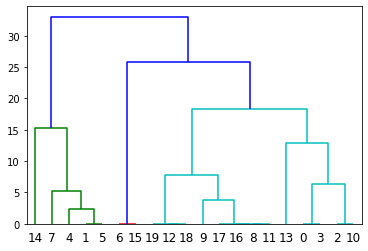

In [29]:
#example

X = [[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #each line is an observation. They can all have same size. Size is number of DAs. What happen if same DA appears twice then?
      [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0],
      [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0],
      [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13],
      [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 11, 0, 0],
      [0, 0, 0, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0],
      [0, 0, 3, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 12, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13],
      [0, 0, 0, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0]]


# X = [[10,20],[5,15],[13,10],[20,10],[1,13],[2,12]]

dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
#interpretation: x_ais labels are the data observation index. Y_axis is the distance between clusters

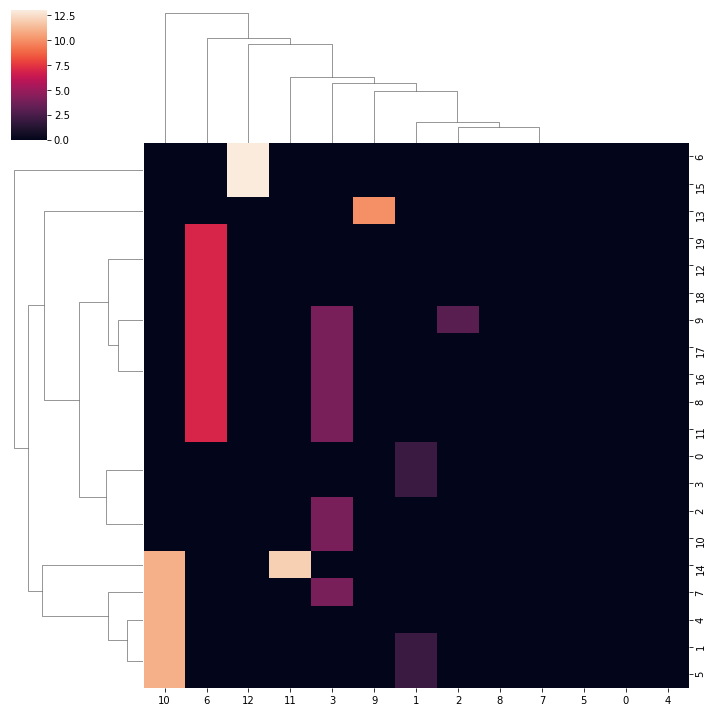

In [19]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.clustermap(X)

In [20]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_


In [21]:
# plt.scatter(X[labels==0,0], X[labels==0,1], s=50, marker='o', color='red')
# plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
# plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.show()

### How to cluster (and plot) findings from baseline and HMM

In [22]:
# step 1: transform all sequences in arrays
# 2: transform them to stacked one hot encodings (like the code below)
#     take as max the highest label over all sequences, so they are all the same size row-wise
#     each line represents one move of the sequences, soo matrices would have different number of rows (and same number of columns)

a = np.array([1, 0, 3])
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
print(b)

#other option: each line is an observation. They can all have same size. 
# Size is number of DAs. What happen if same DA appears twice then?

X = [[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0],
      [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0]]


[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [23]:
# https://stats.stackexchange.com/questions/127484/cluster-sequences-of-data-with-different-length 
import nltk
from nltk import ngrams
a = [1, 15, 1, 1, 13, 14]
b = [1, 1, 1, 1, 12, 1, 7, 11, 9, 11, 7, 11, 7, 11, 7, 4, 7, 7, 14, 15, 9, 2]
c = [13, 1, 13, 15, 13, 2, 9, 2, 9, 2, 2, 2, 2, 2, 2, 2]
d = [1, 2, 9, 1, 6, 10, 6, 1, 6, 10, 14, 3, 10]

bb = list()
bb.append(str(','.join(str(e) for e in ['x' + str(e) for e in a])))
bb.append(str(','.join(str(e) for e in ['x' + str(e) for e in b])))
bb.append(str(','.join(str(e) for e in ['x' + str(e) for e in c])))
bb.append(str(','.join(str(e) for e in ['x' + str(e) for e in d])))

# bb results in list ['x1,x15,x1,x1,x13,x14',
#  'x1,x1,x1,x1,x12,x1,x7,x11,x9,x11,x7,x11,x7,x11,x7,x4,x7,x7,x14,x15,x9,x2',
#  'x13,x1,x13,x15,x13,x2,x9,x2,x9,x2,x2,x2,x2,x2,x2,x2',
#  'x1,x2,x9,x1,x6,x10,x6,x1,x6,x10,x14,x3,x10']

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(bb)
X.toarray()

# basically columns corresponds to words which are
# print(vectorizer.get_feature_names())
# ['x1', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x2', 'x3', 'x4', 'x6', 'x7', 'x9']

# and rows are your samples.
# Now that you have a feature matrix, you can go ahead and do clustering, for example kmeans

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_


######## IF I DO THIS METHOD, SHOULD I PUT EACH SEQUENCE ONCE, OR THE NUMBER OF TIMES THEY EACH OCCUR?
#WHAT IS MY END GAME? WHAT IS THE FINFING I WANT TO PORTRAY?

array([0, 0, 1, 0], dtype=int32)

## Notebook t-sne (in dropbox)

In [30]:
# Time to build our clusters.
# In this kernel, we will be visualizing only three different clusters on our data. 
#I chose three because I found it to be a good number of clusters to help us visualize our data


########### en lugar de kmean use HAC ##########


#Initialize our model
kmeans = KMeans(n_clusters=3)
#Fit our model
kmeans.fit(X)
KMeans(n_clusters=3)
#Find which cluster each data-point belongs to
clusters = kmeans.predict(X)
#Add the cluster vector to our DataFrame, X
df_to_cluster["Cluster"] = clusters

ValueError: Length of values does not match length of index

In [ ]:
#sampling 
#plotX is a DataFrame containing 5000 values sampled randomly from X
plot_df = pd.DataFrame(np.array(df_to_cluster.sample(5000)))

#Rename plotX's columns since it was briefly converted to an np.array above
plot_df.columns = df_to_cluster.columns

# plot_df.head()

In [8]:
#Set our perplexity
perplexity = 50

#T-SNE with two dimensions
tsne_2d = TSNE(n_components=2, perplexity=perplexity)

# #T-SNE with three dimensions
# tsne_3d = TSNE(n_components=3, perplexity=perplexity)

#This DataFrame contains two dimensions, built by T-SNE
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plot_df.drop(["Cluster"], axis=1)))

# #And this DataFrame contains three dimensions, built by T-SNE
# TCs_3d = pd.DataFrame(tsne_3d.fit_transform(df_to_cluster.drop(["Cluster"], axis=1)))

#"TC1_2d" means: 'The first component of the components created for 2-D visualization, by T-SNE.'
#And "TC2_2d" means: 'The second component of the components created for 2-D visualization, by T-SNE.'
TCs_2d.columns = ["TC1_2d","TC2_2d"]

# TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]

df_to_cluster = pd.concat([plot_df,TCs_1d,TCs_2d,TCs_3d], axis=1, join='inner')


#Each of these new DataFrames will hold all of the values contained in exacltly one of the clusters. For example, all of the values contained within the DataFrame, cluster0 will belong to 'cluster 0', and all the values contained in DataFrame, cluster1 will belong to 'cluster 1', etc.

cluster0 = plot_df[plot_df["Cluster"] == 0]
cluster1 = plot_df[plot_df["Cluster"] == 1]
cluster2 = plot_df[plot_df["Cluster"] == 2]


NameError: name 'plot_df' is not defined

In [9]:
#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["TC1_2d"],
                    y = cluster0["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["TC1_2d"],
                    y = cluster1["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["TC1_2d"],
                    y = cluster2["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

NameError: name 'cluster0' is not defined

# BEGIN HERE
## N-grams from Jurafsky

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import statistics

In [ ]:
df = pd.read_csv('./data_TM2/processed_utterances_sentence_DA_labeling.csv', index_col=0)

In [ ]:
####### correct format of column that was string and should be list

import ast

print(type(df['all_DA'][0]))
all_DA = []
for row in range(len(df['all_DA'])):
    inst = ast.literal_eval(df['all_DA'][row])
    inst = [i.strip("[]") for i in inst]
    all_DA.append(inst)
    
df['all_DA'] = all_DA

print(type(df['all_DA'][0]))

In [ ]:
df.drop(df.iloc[:, 8:-1], inplace = True, axis = 1)
df = df.explode('all_DA')
df['all_DA'] = df['all_DA'].fillna('<UNK>')
df['all_DA'].head()

In [ ]:
# #adding unknown token <UNK> for unlabeled utterances and *(removing more than 1 label for each utterance)

# ALL_DA = []
# for row in range(len(df['all_DA'])):
#     if len(df['all_DA'].iloc[row]) == 0:
#         ALL_DA.append(['<UNK>'])
# #     *uncomment the below to leave only one label per utterance. Otherwise multiple labels may be used 
# #     elif len(df['all_DA'].iloc[row]) >1:
# #         ALL_DA.append([df['all_DA'].iloc[row][0]])
#     else:
#         ALL_DA.append(df['all_DA'].iloc[row])
        
# # ALL_DA

In [ ]:
#solution for all dialogues. After This data will be prepared to serve as input

unique_ids = df['conversation_id'].unique()

start = '<s>'
start_dou = '<ss>'
end_dou = '<ee>'
end ='<e>'
full_DA = []  

for dialog in unique_ids:
    dialog_DA = []   
    temp = df.loc[df['conversation_id'] == dialog]
    for x in range(len(temp)):
        dialog_DA.append(temp['all_DA'].iloc[x])

    #insert begin and end tokens for each dialog. This is for bigram only. for tri would need two symbols in the begin and 2 in the end
    dialog_DA.insert(0, start)
    dialog_DA.insert(1, start_dou)
    dialog_DA.append(end_dou)
    dialog_DA.append(end)
    full_DA.append(dialog_DA)

full_DA[0]

In [ ]:
# #for one example of dialog
# start = ['<s>']
# end =['<e>']

# dialog_DA = []   
# temp = df.loc[df['conversation_id'] == 'dlg-00100680-00e0-40fe-8321-6d81b21bfc4f']
# [dialog_DA.append(temp['all_DA'][x]) for x in range(len(temp))]

# #insert begin and end tokens for each dialog. This is for bigram only. for tri would need two symbols in the begin and 2 in the end
# dialog_DA.insert(0, start)
# dialog_DA.append(end)

# dialog_DA

In [ ]:
#flatten nested lists

def flatten(t):
    # https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
    return [item for sublist in t for item in sublist]

# df['labels_UNK_and_SINGLE_DA'] = flatten(ALL_DA)

In [ ]:
#modeling phase
#from this tutorial: https://medium.com/swlh/language-modelling-with-nltk-20eac7e70853#b9bf

import nltk
from nltk.util import ngrams
# from nltk import word_tokenize

unigram=[]
bigram=[]
trigram=[]
fourgram=[]
tokenized_text = flatten(unigram)

#unigram, bigram, trigram, and fourgram models are created
for sequence in full_DA:
    unigram.append(sequence)

bigram.extend(list(ngrams(sequence, 2)))  
trigram.extend(list(ngrams(sequence, 3)))
fourgram.extend(list(ngrams(sequence, 4)))

freq_uni = Counter(flatten(unigram))
freq_bi = nltk.FreqDist(bigram)
freq_tri = nltk.FreqDist(trigram)
freq_four = nltk.FreqDist(fourgram)


print("Most common n-grams without add-1 smoothing: \n")
print ("Most common unigrams: \n", freq_uni.most_common(5))
print ("Most common bigrams: \n", freq_bi.most_common(5))
print ("\nMost common trigrams: \n", freq_tri.most_common(5))
print ("\nMost common fourgrams: \n", freq_four.most_common(5))

In [ ]:
# bigram

In [ ]:
#Add-1 smoothing is performed here. Different value might be better
            
ngrams_all = {1:[], 2:[], 3:[], 4:[]} #from unigram to fourgram in this case
for i in range(4):
    for each in unigram:
        for j in ngrams(each, i+1):
            ngrams_all[i+1].append(j);
ngrams_voc = {1:set([]), 2:set([]), 3:set([]), 4:set([])} #set() method is used to convert any of the iterable to sequence of iterable elements with distinct elements

for i in range(4):
    for gram in ngrams_all[i+1]:
        if gram not in ngrams_voc[i+1]:
            ngrams_voc[i+1].add(gram)
total_ngrams = {1:-1, 2:-1, 3:-1, 4:-1}
total_voc = {1:-1, 2:-1, 3:-1, 4:-1}

for i in range(4):
    total_ngrams[i+1] = len(ngrams_all[i+1])
    total_voc[i+1] = len(ngrams_voc[i+1])                       
    
ngrams_prob = {1:[], 2:[], 3:[], 4:[]}

for i in range(4):
    for ngram in ngrams_voc[i+1]:
        tlist = [ngram]
        tlist.append(ngrams_all[i+1].count(ngram))
        ngrams_prob[i+1].append(tlist)
    
for i in range(4):
    for ngram in ngrams_prob[i+1]:
        ngram[-1] = (ngram[-1])/(total_ngrams[i+1]+total_voc[i+1])             


In [ ]:
#Prints top 10 unigram, bigram, trigram, fourgram
print("Most common n-grams without stopword removal and with add-1 smoothing: \n")
for i in range(4):
    ngrams_prob[i+1] = sorted(ngrams_prob[i+1], key = lambda x:x[1], reverse = True)
    
print ("Most common unigrams: ", str(ngrams_prob[1][:10]))
print ("\nMost common bigrams: ", str(ngrams_prob[2][:10]))
print ("\nMost common trigrams: ", str(ngrams_prob[3][:10]))
print ("\nMost common fourgrams: ", str(ngrams_prob[4][:10]))

### To calculate probability of unseen sequences

In [ ]:
def ngram_prediction(tokenized_sent):
    ngram = {1:[], 2:[], 3:[]}#to store n-grams formed from the strings

    for i in range(1, 4):
        ngram[i] = list(ngrams(tokenized_sent, i))[-1]
    
    print("String: ", ngram)
    
    for j in range(4):
        ngrams_prob[j+1] = sorted(ngrams_prob[j+1], key = lambda x:x[1], reverse = True)
    
    pred = {1:[], 2:[], 3:[]}
    for k in range(3):
        count = 0
        for each in ngrams_prob[k+2]:
            if each[0][:-1] == ngram[k+1]:#to find predictions based on highest probability of n-grams                   
                count +=1
                pred[k+1].append(each[0][-1])
                if count ==5:
                    break
        if count<5:
            while(count!=5):
                pred[k+1].append("NA")#if no word prediction is found, replace with NOT FOUND
                count +=1
                
    return pred, ngrams_prob

token_1 = ['<s>','U_greeting','<UNK>','A_greeting','A_confirmation']
token_2 = ['<s>','U_greeting','A_greeting']
pred_1, ngrams_prob_1 = ngram_prediction(token_1)
pred_2, ngrams_prob_2 = ngram_prediction(token_2)
    

In [ ]:
print("Next word predictions for the strings using the probability models of bigrams, trigrams, and fourgrams\n")
print("String 1 \n")
print("Bigram model predictions: {}\nTrigram model predictions: {}\nFourgram model predictions: {}\n" .format(pred_1[1], pred_1[2], pred_1[3]))
print("String 2 \n")
print("Bigram model predictions: {}\nTrigram model predictions: {}\nFourgram model predictions: {}" .format(pred_2[1], pred_2[2], pred_2[3]))

In [ ]:
#Dict of probabilities from unigram to fourgram

# ngrams_prob

### Perplexity
An intrinsic evaluation metric is one that measures the quality of a model independent of any application.

The perplexity of a language model on a test set is the inverse probability of the test set, normalized by the number of words. Thus the higher the conditional probability of the word sequence, the lower the perplexity, and maximizing the perplexity is equivalent to maximizing the test set probability according to the language model.

https://stackoverflow.com/questions/54941966/how-can-i-calculate-perplexity-using-nltk/55043954#55043954?newreg=b97aa34187184c90988f9a75e51898c2

##### Here we calculate perprexity in the whole dataset. without train, dev, test. Why though??  
Maybe because it's unsupervised??
i've read about v/k folding. also seems to need x and y

In [ ]:
print(len(unigram))

In [ ]:
import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Vocabulary

unigram_train = unigram[0:17000]

n = 2
train_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="<e>") for t in unigram_train]
words = [word for sent in unigram_train for word in sent]
words.extend(["<s>", "<e>"])
padded_vocab = Vocabulary(words)
model = MLE(n)
model.fit(train_data, padded_vocab)

unigram_test = unigram[17000:] # if you want to test just small sample
print(len(unigram_test))

test_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="<e>") for t in unigram_test]

#for each bigram MLE estimate (tuples estimate)
#maximizing a likelihood function so that, under the assumed statistical model, the observed data is most probable.
#if you don't want to see MLE per tuple comment print line

for test in test_data:
#     print ("MLE Estimates:", [((ngram[-1], ngram[:-1]),model.score(ngram[-1], ngram[:-1])) for ngram in test]) # will generate one estimator per input. Here each input contains all DA labels for one dialog sequence.
    pass

#for whole dialog perplexity calculation.
#if print unigram_test[i] you see sentence and perplexity. 
#to make it easier to read perplexities (not caring about the specific sentence) print second line (only i)

test_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="<e>") for t in unigram_test]

for i, test in enumerate(test_data):
#     print("PP({0}):{1}".format(unigram_test[i], model.perplexity(test)))
    print("PP({0}):{1}".format(i, model.perplexity(test)))


In [ ]:
uni = {}
bi = {}
tri = {}
four = {}

######## this alternative version makes some parts of the code not to work for bi,tri,four.

for key, value in ngrams_prob.items():
    for lista in value:
#         lista[0] = str(lista[0])
#         lista[0] = re.sub(r"['(),]", "", lista[0])
        
        if key ==1:
            lista[0] = str(lista[0])
            lista[0] = re.sub(r"['(),]", "", lista[0])
            uni[lista[0]] = lista[1]
        if key ==2:
            bi[lista[0]] = lista[1]
        if key ==3:
            tri[lista[0]] = lista[1]
        if key ==4:
            four[lista[0]] = lista[1]

In [ ]:
############################
# ### transform bigram probabilities into dataframe
# tmp = []
# values = []

# for key, value in bi.items():
#     values.append(value)
#     for item in key.split(' '):
#         tmp.append(item)
        

# row = [] # row = itens pares de tmp
# column = [] # columns = itens impares de tmp

# for i in range(len(tmp)):
#     if i % 2 == 0: row.append(tmp[i])
#     else: column.append(tmp[i])

In [ ]:
# ############################
# #sanity checks
# print(len(np.unique(row)) == len(np.unique(column)))
# print(row[3],column[3],values[3])

In [ ]:
############################
# unique_da = np.unique(row) #24 unique DAs
# mat = np.zeros((len(unique_da),len(unique_da))) #empty matrix shape unique DA. here 20x20

# for e, da1 in enumerate(unique_da):
#     for f, da2 in enumerate(unique_da):
#         for i in range(len(row)):
#             if da1 == row[i] and da2 == column[i]:
#                 mat[e][f] = values[i]
                

In [ ]:
############################
# #teste e funcionaaa. comparar com os resultados da lista bi
# print(mat[3][12]) #'A_confirmation A_sequence_closer': 0.045319277995720685

In [ ]:
############################
# emition_p_df = pd.DataFrame(mat, index=unique_da, columns=unique_da)
# emition_p_df

### Make emission probabilities for hidden state New

- use shift(1) por exemplo
- count +=1 for that combination of 2 labels every time one label is followed by next. 
- I want to calculate for t, the p(t|t+1) for bigrams and p(t|t+1)*p(t+1|t+2)
- format: 
    - bi: {('A_confirmation', 'A_sequence_closer'): 0.042966175117006435,
    - tri: {('U_answer', 'A_confirmation', 'A_sequence_closer'): 0.018695486830967774,

In [ ]:
# unique da counting special symbols
da_u = [] #uni.keys()
[da_u.append(k) for k in uni.keys()]

#create shifted DA for future bigram
df['shifted_DA_bi'] = df['all_DA'].shift(-1)

#create shifted DA for future trigram
df['shifted_DA_tri'] = df['all_DA'].shift(-2)
df.head()

In [ ]:
#count occurrences of each DA

df = df.reset_index(drop=True)
count_DA = df['all_DA'].value_counts().reset_index(name='Counts')
count_DA.iloc[0, 0]
count_da = {}
for e in range(len(count_DA)):
    count_da[count_DA.iloc[e, 0]] = count_DA.iloc[e, 1]

count_da

#create list of all possible unique bigrams and trigrams. order matters

da_tuples = []

for fir in range(len(da_u)):
    for sec in range(len(da_u)):
        da_tuples.append((da_u[fir], da_u[sec]))


da_triples = []

for fir in range(len(da_u)):
    for sec in range(len(da_u)):
        for thir in range(len(da_u)):
            da_triples.append((da_u[fir],da_u[sec], da_u[thir]))


#sanity check bi and tri
print(len(da_tuples) == len(da_u)*len(da_u), len(da_tuples))
print(len(da_triples) == len(da_u)**3, len(da_triples))



#count occurrences for bigrams
bi_next = {}

for row in range(len(df)-1):
    k = (df['all_DA'][row], df['shifted_DA_bi'][row])            
    bi_next[k] = bi_next[k] + 1 if k in bi_next else 1
    
bi_next

#count occurrences for trigrams
tri_next = {}

for row in range(len(df)-1):
    k = (df['all_DA'][row], df['shifted_DA_bi'][row], df['shifted_DA_tri'][row])            
    tri_next[k] = tri_next[k] + 1 if k in tri_next else 1
    
# tri_next

## Correct past bi/trigrams (including all possible examples, now it has only non zero examples)

In [ ]:
# bi_past same as bi, but if there is no match prob will be set to 0.00000000000001 or sth very low
#same has to be done for tri_past and tri

bi_past = {} #use da_tuples list ad basis, since contains all possibilities
tri_past = {} #use da_triples list ad basis, since contains all possibilities
          
for dupla in da_tuples: #list containing all possible tuples of bigram
    bi_past[dupla] = 0.0000000001 
    for k in bi.keys():
        if k == dupla:
            bi_past[dupla] = bi.get(k)
            
for tripla in da_triples: #list containing all possible tuples of bigram
    tri_past[tripla] = 0.0000000001 
    for ka in tri.keys():
        if ka == tripla:
            tri_past[tripla] = tri.get(ka)

#sanity check
print(len(bi_past) == len(da_u)**2, len(bi_past))
print(len(tri_past) == len(da_u)**3, len(tri_past))

## Future bi/trigrams

In [ ]:
bi_fut = {}
for A in da_u:
    for B in da_u:
        bi_fut[(A,B)] = bi_past.get((A,B))*uni.get(A)/uni.get(B)
        
tri_fut = {}
for e, A in enumerate(da_u):
    for f, B in enumerate(da_u):
        for g, C in enumerate(da_u):
            tri_fut[(A,B,C)] = tri_past.get((A,B,C))*bi_past.get((A,C))/bi_past.get((B,C))

#sanity check
print(len(bi_fut) == len(bi_past))
print(len(tri_fut) == len(tri_past))

## HMM

from wikipedia, code inclusive: https://en.wikipedia.org/wiki/Viterbi_algorithm#Pseudocode

In [ ]:
# #viterbi working version explained

# def viterbi(obs, states, start_p, trans_p, emit_p):
#     V = [{}]
#     for st in states:
#         V[0] [st] = {"prob": start_p[st] * emit_p[st] [obs[0]], "prev": None}
        
# #         print(obs[0]) # <s>
# #         print(V[0]) #{'New': {'prob': 0.026402178674778336, 'prev': None}}
# #         print(V[0][st]) #{'prob': 0.026402178674778336, 'prev': None}
        
# #         print(emit_p[st]) #{'<UNK>': 0.13607616415027982, 'A_detail_request': 0.09849232743674069, 'U_answer': 0.08896718105028044, 'U_sequence_closer': 0.08872037563783773, 'A_greeting': 0.08228646704222224, 'A_sequence_closer': 0.07324259121002523, 'U_confirmation': 0.07295413738423284, 'A_confirmation': 0.07257621659642996, 'U_partial_request': 0.07246823922848628, 'A_grant': 0.06559316595812946, 'U_greeting': 0.058711922552461576, '<s>': 0.026668867348260947, '<e>': 0.026668867348260947, 'A_completion_check': 0.009955513324407203, 'A_hold_request': 0.009088609313202238, 'A_receipt': 0.006598959715186554, 'A_request_summary': 0.002805869032707887, 'A_repair_initiator': 0.0024094378389718086, 'A_disconfirmation': 0.0019713582318860254, 'U_request_summary': 0.0011461026340307643, 'U_disconfirmation': 0.001110624355992127, 'U_repair_initiator': 0.0008499361390995304, 'U_receipt': 0.0002406352771316275, 'U_completion_check': 0.0002190398035428917, 'U_hold_request': 0.00013882804449901587}
# #         print(emit_p[st] [obs[0]]) #0.026668867348260947, que é o de <s> no caso do primeiro state
        

#     # Run Viterbi when t > 0
#     for t in range(1, len(obs)):
#         V.append({})
#         for st in states:
# #             print(st) #new and current
#             max_tr_prob = V[t - 1] [states[0]] ["prob"] * trans_p[states[0]] [st] #0.026402178674778336*0.1 and same*0.9
            
# #             print(V)
# #             print(V[t]) #AQUI SOLO SALE NEW EM TODOS OS Ts{'New': {'prob': 0.00021725420053650106, 'prev': 'New'}} OR ON NEXT T: {'New': {'prob': 6.887922369891843e-05, 'prev': 'Current'}}
# #             print(V[t - 1]) #AQUI SAI O ANTERIOR TANTO PRA NEW QUANTO CURRENT:{'New': {'prob': 0.026402178674778336, 'prev': None}, 'Current': {'prob': 0.0002666886734826095, 'prev': None}}
# #             print(V[t - 1] [states[0]]) #choose higher prob{'prob': 0.026402178674778336, 'prev': None}
# #             print(V[t - 1] [states[0]] ["prob"]) # 0.026402178674778336
            
# #             print(trans_p) #always the same: {'New': {'New': 0.1, 'Current': 0.9}, 'Current': {'New': 0.6, 'Current': 0.4}}
# #             print(trans_p[states[0]]) #from state 0: {'New': 0.1, 'Current': 0.9}
# #             print(trans_p[states[0]] [st]) #first iteration: 0.1, next iteration: 0.9 and repeats
            
            
#             prev_st_selected = states[0]
# #             print(states[1:])
#             for prev_st in states[1:]:
#                 tr_prob = V[t - 1] [prev_st] ["prob"] * trans_p[prev_st] [st] # a diferenca aqui em relacao ao max_tr_prob é que aqui se calcula o previous state
#                 if tr_prob > max_tr_prob: #if other state is higher than state 0 (i.e if Current > New)
#                     max_tr_prob = tr_prob #then new max is Current instead on New. Here we store the actual probability
#                     prev_st_selected = prev_st #and previous state is updated. Here we store name of state

#             max_prob = max_tr_prob * emit_p[st] [obs[t]] #prob of state* emission prob of the DA being observed
#             V[t] [st] = {"prob": max_prob, "prev": prev_st_selected}
# #             print(V[t])
# #             print(V[t-1])
# #             print(emit_p) #whole dictionary is used as input including key 'New': whole dict, 'Current': whole dict
# #             print(emit_p[st]) #whole dictionary is used as input, but the key 'New' and 'Current' don't appear anymore
# #             print(obs[t]) #Current DA
# #             print(obs[t-1]) #previous DA. this works because is from second onwards
# #             print(emit_p[st] [obs[t]])


#     for line in dptable(V):
#         print(line)

#     optimal = []
#     max_prob = 0.0
#     best_st = None
#     # Get most probable state and its backtrack
#     for st, data in V[-1].items(): #V[-1] is the last dic. ex: {'New': {'prob': 6.983898154776834e-19, 'prev': 'Current'}, 'Current': {'prob': 1.5713770848247866e-18, 'prev': 'New'}
# #         print(data) #{'prob': 6.983898154776834e-19, 'prev': 'Current'}
#         if data["prob"] > max_prob: #6.983898154776834e-19 > 0.0 (in first step)
#             max_prob = data["prob"] #update max prob to compare with second state in next iteration
# #             print(max_prob)
#             best_st = st
#     optimal.append(best_st) #appending all best states
#     previous = best_st #updating previous as best state to be used later


#     # Follow the backtrack till the first observation
#     for t in range(len(V) - 2, -1, -1): # start=len(V)-2, stop=-1, step=-1. Calculates from last step to first
#         print(t, len(V))
#         optimal.insert(0, V[t + 1] [previous] ["prev"])
#         previous = V[t + 1] [previous] ["prev"]

#     print ("The steps of states are " + " ".join(optimal) + " with highest probability of %s" % max_prob)
# #     print(V) #probability of each state given all possible previous states

# def dptable(V):
#     # Print a table of steps from dictionary
#     yield " " * 5 + "     ".join(("%3d" % i) for i in range(len(V)))
#     for state in V[0]:
#         yield "%.7s: " % state + " ".join("%.7s" % ("%lf" % v[state] ["prob"]) for v in V)

In [ ]:
# ######## FUNCTIONING CODE FOR BIGRAMS #########
# ######PS: this would need as input sentences with padding=1


# def viterbi(obs, states, start_p, trans_p, emit_p, emit_p_bi, emit_p_tri): 
#     V = [{}]
#     for st in states:
#         V[0] [st] = {"prob": start_p[st] * emit_p[st] [obs[0]], "prev": None}


#     # Run Viterbi when t > 0
#     for t in range(1, len(obs)): 

#         V.append({})
#         for st in states: #New and Current
#             max_tr_prob = V[t - 1] [states[0]] ["prob"] * trans_p[states[0]] [st] #0.026402178674778336*0.1 and same*0.9 ###### OLD
#             prev_st_selected = states[0] 

#             for prev_st in states[1:]:
#                 tr_prob = V[t - 1] [prev_st] ["prob"] * trans_p[prev_st] [st] # a diferenca aqui em relacao ao max_tr_prob é que aqui se calcula o previous state
#                 if tr_prob > max_tr_prob: #if other state is higher than state 0 (i.e if Current > New)
#                     max_tr_prob = tr_prob #then new max is Current instead on New. Here we store the actual probability
#                     prev_st_selected = prev_st #and previous state is updated. Here we store name of state

#             ############# NEW to include emit_p for bigram
#             max_prob = max_tr_prob * statistics.fmean([emit_p[st] [obs[t]],emit_p_bi[state].get((obs[t-1],obs[t]))]) #use average
                      
#             V[t] [st] = {"prob": max_prob, "prev": prev_st_selected}

#     for line in dptable(V):
#         print(line)

#     optimal = []
#     max_prob = 0.0
#     best_st = None
#     # Get most probable state and its backtrack
#     for st, data in V[-1].items(): # V[-1] is the last dic. ex: {'New': {'prob': 6.983898154776834e-19, 'prev': 'Current'}, 'Current': {'prob': 1.5713770848247866e-18, 'prev': 'New'}
#         if data["prob"] > max_prob: #6.983898154776834e-19 > 0.0 (in first step)
#             max_prob = data["prob"] #update max prob to compare with second state in next iteration
#             best_st = st
#     optimal.append(best_st) #appending all best states
#     previous = best_st #updating previous as best state to be used later
    
#     print(V)
#     # Follow the backtrack till the first observation
#     for t in range(len(V) - 2, -1, -1): # start=len(V)-2, stop=-1, step=-1. Calculates from last step to first
#         optimal.insert(0, V[t + 1] [previous] ["prev"])
#         previous = V[t + 1] [previous] ["prev"]
#         print(t, previous)

#     print ("The steps of states are " + " ".join(optimal) + " with highest probability of %s" % max_prob)

# def dptable(V):
#     # Print a table of steps from dictionary
#     yield " " * 5 + "     ".join(("%3d" % i) for i in range(len(V)))
#     for state in V[0]:
#         yield "%.7s: " % state + " ".join("%.7s" % ("%lf" % v[state] ["prob"]) for v in V)

In [ ]:
###### TRIGRAMS
######PS: this would need as input sentences with padding=2 (each side)

def viterbi(obs, states, start_p, trans_p, emit_p, emit_p_bi, emit_p_tri): 
    V = [{}]

    for st in states:
        V[0] [st] = {"prob": start_p[st] * emit_p[st] [obs[0]], "prev": None} #### OLD
        V.append({})
        V[1] [st] = {"prob": start_p[st] * emit_p[st] [obs[1]], "prev": None} #### NEW


    # Run Viterbi when t > 1
    for t in range(2, len(obs)-2): #in my example len(obs)=32. i.e: range 2, 31 inclusive
        V.append({})
        for st in states: #New and Current            
            max_tr_prob = V[t - 1] [states[0]] ["prob"] * trans_p[states[0]] [st] #0.026402178674778336*0.1 and same*0.9 ######### NEW
            prev_st_selected = states[0] 
            
            for prev_st in states[1:]: #(states[1:]) >>> Current
                tr_prob = V[t - 1] [prev_st] ["prob"] * trans_p[prev_st] [st] # a diferenca aqui em relacao ao max_tr_prob é que aqui se calcula o previous state
                if tr_prob > max_tr_prob: #if other state is higher than state 0 (i.e if Current > New)
                    max_tr_prob = tr_prob #then new max is Current instead on New. Here we store the actual probability
                    prev_st_selected = prev_st #and previous state is updated. Here we store name of state

            ######################################## includes emit_p for trigram,bigram and unigram
            
            # max_prob = max_tr_prob * statistics.fmean([emit_p[st] [obs[t]],emit_p_bi[state].get((obs[t-1],obs[t])), emit_p_tri[state].get((obs[t-2],obs[t-1],obs[t]))]) 

            ####################################### includes emit_p for trigram,bigram and unigram if new and if current
            if st == 'New':
                max_prob = max_tr_prob * statistics.fmean([emit_p[st] [obs[t]], emit_p_bi[state].get((obs[t],obs[t+1])), emit_p_tri[state].get((obs[t],obs[t+1],obs[t+2]))]) 
            elif st == 'Current':
                max_prob = max_tr_prob * statistics.fmean([emit_p[st] [obs[t]], emit_p_bi[state].get((obs[t-1],obs[t])), emit_p_tri[state].get((obs[t-2],obs[t-1],obs[t]))]) 
            
            
            V[t] [st] = {"prob": max_prob, "prev": prev_st_selected}

    V = V[:-1]
#     for line in dptable(V):
#         print(line)

    optimal = []
    max_prob = 0.0
    best_st = None
    
    # Get most probable state and its backtrack
    for st, data in V[-1].items(): # V[-1] is the last dic. ex: {'New': {'prob': 6.983898154776834e-19, 'prev': 'Current'}, 'Current': {'prob': 1.5713770848247866e-18, 'prev': 'New'}
        if data["prob"] > max_prob: #6.983898154776834e-19 > 0.0 (in first step)
            max_prob = data["prob"] #update max prob to compare with second state in next iteration
            best_st = st
    optimal.append(best_st) #appending all best states
    previous = best_st #updating previous as best state to be used later


    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1): # start=len(V)-2, stop=-1, step=-1. Calculates from last step to first ###### NEW
        optimal.insert(0, V[t + 1] [previous] ["prev"])
        previous = V[t + 1] [previous] ["prev"]
    optimal = optimal[1:]
    
#     print ("The steps of states are " + " ".join(optimal) + " with highest probability of %s" % max_prob)
    return optimal, max_prob

def dptable(V):
    # Print a table of steps from dictionary
    yield " " * 5 + "     ".join(("%3d" % i) for i in range(len(V)))
    for state in V[0]:
        yield "%.7s: " % state + " ".join("%.7s" % ("%lf" % v[state] ["prob"]) for v in V)

In [ ]:
#trigrams add slighly more current sequences. with unigrams no sequences, always cycle [New,Current,New,Current...]
obs = unigram[3] # just an example
states = ['New', 'Current']
start_p = {'New':0.9999,'Current':0.0001}

Cur = 0.6+1e-70
Ne = 1 - Cur

trans_p = {'New': {'New':0.1,'Current':0.9}, 'Current': {'New': Ne,'Current':Cur}} #the higher current, more it appears. 0.6 too litle, 0.7 too much
emit_uni = {}
emit_bi = {}
emit_tri = {}

emit_uni['New'] = uni
emit_uni['Current'] = uni 
emit_bi['New'] = bi_fut 
emit_bi['Current'] = bi_past 
emit_tri['New'] = tri_fut 
emit_tri['Current'] = tri_past 

seq, pro = viterbi(obs, states, start_p, trans_p, emit_uni, emit_bi, emit_tri) #steps are being rounded to zero cause prob is much smaller. Final is around e-18


## Statistics with whole dataset

In [ ]:
# depois mapping unigram[i]:hmm_seq[i]

#call function for all dialogues with repair initiator. save in dict in which key=dialogue id and value=paraphrase  
    
hmm_seq = []
count =0
for dialog in unigram:
    try:
        seq, p = viterbi(dialog, states, start_p, trans_p, emit_uni, emit_bi, emit_tri)
        hmm_seq.append([dialog[2:-1], seq, p]) #remove extra symbols from dialog (<s>, <ss>, <e>)
    except Exception:
        count+=1
        pass

print(len(hmm_seq))
print(count)

In [ ]:
# printing examples

print(len(hmm_seq[2][0]))
print(len(hmm_seq[2][1]))
print(hmm_seq[2][0])
print(hmm_seq[2][1])


#is it two less in begin and 1 in the end or both is the beginning
# insert None, None in begining and one None in the end 

In [ ]:
from more_itertools import locate

all_da_seq = []
all_hid_seq = []
count = 0

for i in range(len(hmm_seq)):
    s_da = hmm_seq[i][0]
    s_hid = hmm_seq[i][1]
    
    if len(s_da)==len(s_hid): #sanity check that all contain same len
        index_new = list(locate(teste, lambda a: a == 'New'))
        split_hidden_lab = [s_hid[i : j] for i, j in zip([0] +  index_new, index_new + [None])]
        split_da_lab = [s_da[i : j] for i, j in zip([0] +  index_new, index_new + [None])]

        all_hid_seq.append(split_hidden_lab)
        all_da_seq.append(split_da_lab)
    else: count+=1

# all_da_seq

In [ ]:
#count times each da sequence appear. put in dict. k==seq, value ==count
seq_counts = {}

for seq in all_da_seq:
    for sub_seq in seq:
        sub_seq = ' '.join(sub_seq)
        seq_counts[sub_seq] = seq_counts[sub_seq] + 1 if sub_seq in seq_counts else 1
        
        
import operator

sorted_d = dict(sorted(seq_counts.items(), key=operator.itemgetter(1),reverse=True))
len(sorted_d)

In [ ]:
#getting some ideas on statistics. min and max sequence len.
#see without grouping histrogram/bar of counts per key 
#also group counts per len to seemost frequent sizes of sequences
#plot stacked bar como em titanic. cada bar é uma seq len, cada stacked value inside é a sequencia. 
####pra isso criar nova coluna com a len de cada

seq_to_plot = []

for key, value in sorted_d.items():
    seq_to_plot.append(key.split(' '))
    
max_len = len(max(seq_to_plot))
min_len = len(min(seq_to_plot))

seq_sizes = {}

for seq in seq_to_plot:
    for leng in range(max_len):
        if len(seq) == leng:
            seq_sizes[leng] = seq_sizes[leng] + sorted_d.get(' '.join(seq)) if leng in seq_sizes else sorted_d.get(' '.join(seq))

print('minimum len: '+ str(min_len))
print('maximum len: '+ str(max_len))
print('counts of number of sequences of each len (ranking): ' + str(sorted(seq_sizes.items(), key=operator.itemgetter(1),reverse=True)))
seq_sizes #shows as key the sequence length and value the sum of all sequences of same length
sorted_d # all sequences with its individual counts

# #to see only sequences of specific len I can use the below:
# for e, seq in enumerate(seq_to_plot):
#     if len(seq) ==10:
#         print(seq, sorted_d.get(' '.join(seq)))


In [ ]:
import matplotlib.pyplot as plt

names = list(seq_sizes.keys())
values = list(seq_sizes.values())

plt.bar(range(len(seq_sizes)), values, tick_label=names)
plt.show()

In [ ]:
#isso seria pra plotear todos os elementos do dict
sorted_names = list(sorted_d.keys())
sorted_values = list(sorted_d.values())
sorted_len_each_seq = []

for s in seq_to_plot:
#     print(len(s), s)
    sorted_len_each_seq.append(len(s))

df_plot = pd.DataFrame(list(zip(sorted_names, sorted_values, sorted_len_each_seq)),columns =['Name', 'values', 'seq_len'])

df_plot.drop(0, axis=0, inplace=True)
df_plot.head()

    
# pd.crosstab(df_plot['seq_len'], df_plot['Name']).plot(kind = 'bar', stacked = True)

In [ ]:
#### CHECK WHY ABOVE SAYS THE MAX SEQ LEN IS 10 AND HERE IT SAYS 116

print(df_plot['seq_len'].max())
print('mean len: '+ str(df_plot['seq_len'].mean()))
df_plot.hist('seq_len')

- observations:
 
This is the sequence of Dialog acts in the conversation.
 
- states:
 
The hidden states are one of the following:

    - current pattern (e.g.: stay in pattern)
    - new pattern  
Note that the start / transition / emition probabilities are linked to these two states
 
- start probability: most probable first move. i.e.: bigrams taking only probability of all combinations that start with \<s> symbol.
Should I include here trigrams and fourgrams that also start with \<s> symbol?
 
Here you can simply assign a 1.0 probability for new pattern and 0.0 for current pattern – a conversation always starts with a new pattern.
 
- transition probability: boundaries between moves (probabilities generated in the LM: probabilities of tuples bigram for simplification - could also be trigram, 4gram...)
 
This you can also set yourself, and you can play around with different values. There will be four values:
 
    - from current to current (e.g.: stay in current pattern, will by definition be the third DA or higher in a pattern, since the first DA in a pattern is always of the hidden state ‘new’)
    - from current to new (e.g.: transition to new pattern, setting this one to a high value will likely lead to quite some smaller patterns as output)
    - from new to new (just started a new pattern and directly go to new one, not so realistic and you can set this one very low or simply to 0.0)
    - from new to current (just started a new pattern and staying in it)

- emition probability: unigram probabilities (prob of each move happening at all)
 
Here you will make use of all LM probabilities that you have at any point, but it should be linked to the two stages:
 
    - the probability that a DA is a start of a new pattern at any point can be based on the following information:
        - unigram probability of the DA
        - the bigram probability of the DA as start with the next DA (if any) as second move (e.g.: the DA as first move conditioned on the next DA as second move in the bigram, basically the other way around than is typically done in an LM)
        - the trigram probability of the DA as start conditioned on the next two moves
            - These values are probably not part of your currently trained LM, and may also be omitted
    - the probability that a DA is a continuation of the current pattern can be based on the following information:
        - the bigram probability  of the DA conditioned on the previous DA
        - the trigram probability of the DA conditioned on the previous two Das
        - etc.
 
This latter part may be a bit tricky – in essence you want to follow different paths: you want to consider the trigram probability if in a certain path there is a pattern going on for two moves. If it is not possible to include these different paths, you may also take the average of the different values (bigram, trigram, etc.).
 

In [ ]:
# generic example to test code:

# obs = ["normal", "cold", "dizzy","dizzy","normal", "dizzy"]
# states = ("Healthy", "Fever")
# start_p = {"Healthy": 0.6, "Fever": 0.4}
# trans_p = {
#     "Healthy": {"Healthy": 0.7, "Fever": 0.3},
#     "Fever": {"Healthy": 0.4, "Fever": 0.6},
# }
# emit_p = {
#     "Healthy": {"normal": 0.5, "cold": 0.4, "dizzy": 0.1},
#     "Fever": {"normal": 0.1, "cold": 0.3, "dizzy": 0.6},
# }

# viterbi(obs, states, start_p, trans_p, emit_p)

In [ ]:
# prob of bi = cada row do bigram / numero de paricoes da palavra nos counts unicos
# ex: ('A_sequence_closer', 'U_confirmation'): 2467/ 'A_sequence_closer': 47482 (sequence closer count)

# 2467/47482

# update bi_next com probabilities
# bi_next.values = value/frequencia 

#dessa forma cada primeiro elemento do bigrama somaria 1 al final. conferir se e'isso que eu quero ou se quero a mesma conta pero dividido pelo segundo item
#tem que ser o contrario do bigrama atual

#baseado nisso a probabilidade é normalizada dividindo por todos os possiveis bigramas do dataset
# sum(tri_past.values())

# #eu quero P(t|t+1) #bayes? olhar como calcular essa probabilidade
# A= t (primeira temporalmente)
# B= t+1 (segunda temporalmente)
# # bayes_2 = lambda A,B: P(A|B) = P(B|A)*P(A)/P(B)
# # **primeira e segunda temporalmente, sequencialmente
# # p(primeira|segunda) = p(segunda|primeira)*p(primeira)/p(segunda)

# bi[A][B]*uni[A]/uni[B]

# # conditioned version with 3 events: 
# #https://en.wikipedia.org/wiki/Bayes%27_theorem
# A= t
# B= t+1
# C= t+2
# # bayes_3 = lambda A,B,C: P(A|B,C) = P(B|A,C)*P(A|C)/P(B|C)
# tri[A][B][C]*bi[A][C]/bi[B][C]

# exemplo:
# bi['A_confirmation', 'A_sequence_closer'] >>> p(segunda|primeira)

In [ ]:
# def bi_tri_future_p(obs,uni,bi,tri):
    
    
#     A= obs[t] #(primeira temporalmente)
#     B= obs[t+1] #(segunda temporalmente)
#     C= obs[t+2] #(terceira temporalmente)
    
#     bi_fut = {}
#     tri_fut = {}
    
#     bi_future = bi.get((A,B))*uni(A)/uni(B)
#     tri_future = tri.get((A,B,C))*bi.get((A,C))/bi.get((B,C))
    
#     bi_fut[(A,B)] = bi_future
#     tri_fut[(A,B,C)] = tri_future
    
#     return bi_fut, tri_fut

# A= obs[t] #(primeira temporalmente)
# B= obs[t+1] #(segunda temporalmente)
# C= obs[t+2] #(terceira temporalmente)

# bi_fut = {}
# for A in range(len(da_tuples)):
#     for B in range(len(da_tuples)):
#         bi_future = bi_past.get((A,B))*uni.get(A)/uni.get(B)

#         bi_fut[(A,B)] = bi_future
    
# tri_fut = {}   
# for A in range(len(da_tuples)):
#     for B in range(len(da_tuples)):
#         for C in range(len(da_tuples)):
#             tri_future = tri_past.get((A,B,C))*bi_past.get((A,C))/bi_past.get((B,C))

#             tri_fut[(A,B,C)] = tri_future

##########################################

# da_tuples = []
# bi_fut = {}

# for fir in range(len(da_u)):
#     for sec in range(len(da_u)):
#         da_tuples.append((da_u[fir], da_u[sec]))
#         bi_fut[(da_u[fir], da_u[sec])] = bi.get((fir,sec))*uni.get(fir)/uni.get(sec)